In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import yfinance as yf
from datetime import time 


In [3]:
from datetime import datetime as dt
start  = dt(2020,7,5)
end = dt(2020,8,30)
raw_data = yf.download('^NSEI', start = start, end = end, interval ='5m')
data = raw_data.drop(["Volume","Adj Close"], axis=1)
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close
Datetime,,,,
2020-07-06 09:15:00+05:30,10723.849609,10723.849609,10695.950195,10705.750000
2020-07-06 09:20:00+05:30,10705.549805,10718.849609,10705.549805,10718.849609
2020-07-06 09:25:00+05:30,10718.500000,10718.500000,10704.349609,10713.500000
2020-07-06 09:30:00+05:30,10713.700195,10727.700195,10713.700195,10727.599609
2020-07-06 09:35:00+05:30,10727.400391,10731.150391,10722.000000,10723.599609


In [4]:
def rsi(df, n):
    
    temp = pd.DataFrame()
    temp['UpI'] = df['High'].shift(-1)-df['High']
    temp['DoI'] = df['Low']-df['Low'].shift(-1)
    
    temp.UpI = (temp.UpI>temp.DoI)*(temp.UpI>0)*(temp.UpI)
    temp.DoI = (temp.DoI>temp.UpI)*(temp.DoI>0)*(temp.DoI)
    
    PosDI = pd.Series(temp.UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(temp.DoI.ewm(span=n, min_periods=n).mean())
    
    RSI = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
    df = df.join(RSI)
    return df
def exp_ma(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
def exp_ma_exp_ma(df, n):
    EMA = exp_ma(df,n)
    EMA_EMA = pd.Series(EMA.ewm(span=n, min_periods=n).mean(), name='EMA_EMA_' + str(n))
    return EMA_EMA
def DEMA(df,n):
    DEMA = pd.Series(2*exp_ma(df,n)-exp_ma_exp_ma(df,n), name='DEMA_' + str(n))
    return DEMA
         

In [5]:
data  = rsi(data, 4)
data = data.join(DEMA(data,2)).join(DEMA(data,10))
data.dropna(inplace = True)
data.head()

C:\Users\ARCHIT\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


,Open,High,Low,Close,RSI_4,DEMA_2,DEMA_10
Datetime,,,,,,,
2020-07-06 10:45:00+05:30,10736.650391,10743.549805,10735.750000,10741.700195,0.872509,10741.052292,10738.023726
2020-07-06 10:50:00+05:30,10741.349609,10745.799805,10738.799805,10744.849609,0.804358,10744.741105,10740.497037
2020-07-06 10:55:00+05:30,10743.849609,10745.400391,10738.400391,10742.200195,0.381519,10742.844162,10741.394439
2020-07-06 11:00:00+05:30,10742.500000,10746.049805,10735.000000,10738.599609,0.381519,10739.146663,10740.822841
2020-07-06 11:05:00+05:30,10738.500000,10745.250000,10738.500000,10744.000000,0.763068,10743.293042,10742.165076


In [6]:
data['Long_tag'] = False
#data['Buy_tag'] = np.where(data.index.time<time(15,15), True, False)
data.loc[(data['DEMA_2']>data['DEMA_10']) &
         (data['RSI_4']<0.3),'Long_tag'] = True
data['Short_tag'] = False
#data['Sell_tag'] = np.where(data.index.time>time(15,15), True, False)
data.loc[(data['DEMA_2']<data['DEMA_10']) &
         (data['RSI_4']>0.3),'Short_tag'] = True

In [7]:
data.drop(['High','Low','Open'],axis = 1, inplace =True)
data.head()

,Close,RSI_4,DEMA_2,DEMA_10,Long_tag,Short_tag
Datetime,,,,,,
2020-07-06 10:45:00+05:30,10741.700195,0.872509,10741.052292,10738.023726,False,False
2020-07-06 10:50:00+05:30,10744.849609,0.804358,10744.741105,10740.497037,False,False
2020-07-06 10:55:00+05:30,10742.200195,0.381519,10742.844162,10741.394439,False,False
2020-07-06 11:00:00+05:30,10738.599609,0.381519,10739.146663,10740.822841,False,True
2020-07-06 11:05:00+05:30,10744.000000,0.763068,10743.293042,10742.165076,False,False


In [8]:
#def T_costs_long(buy,sell, n):
#    T_costs = 1.18(min(0.0003*buy, 20) +0.0000325*max(sell-buy,0)) + 0.0025*sell #SEBI charges not included 
#    return T_costs

#def T_costs_short(buy,sell, n):
#    T_costs = 1.18(min(0.0003*buy, 20) -0.0000325*min(sell-buy,0)) + 0.0025*sell #SEBI charges not included 
#    return T_costs

In [9]:
Initial_capital = 200000         # brokerage =100   #stoploss =0.5
positions  = 150
active_pos = 0
data['Long_cover'] =0
data['Short_sell'] =0
data['Short_cover'] =0
data['active_cash'] =0
data['Long_buy']=0
active_cash = Initial_capital
long_pos = 0
short_pos = 0
k=0
d=0


In [10]:
for i in data.index:
    k+=1
    if long_pos>0 and (data.loc[i,'Short_tag'] or i.time() > time(15,15)):  #covering long
        j=0
        for j  in range(k):
            if data['Long_buy'].iloc[j]!=0 and data['Long_cover'].iloc[j]==0 :
                data['Long_cover'].iloc[j] = data['Close'].loc[i]* long_pos -100* long_pos
                active_cash+= data['Close'].loc[i]* long_pos               
                data['Long_buy'].iloc[j]=0
                long_pos = 0
        #print('v')

    if short_pos>0 and (data.loc[i,'Long_tag'] or i.time() > time(15,15)):  #covering short
        j=0
        for j in range(k):
            if data['Short_sell'].iloc[j]!=0 and data['Short_cover'].iloc[j]==0:
                data['Short_cover'].iloc[j] = data['Close'].loc[i]* short_pos
                active_cash += data['Close'].loc[i]* short_pos           
                data['Short_sell'].iloc[j]=0
                short_pos = 0
        #print('c')
    
    if long_pos>0 and (data.loc[i,'Short_tag'] or i.time() < time(15,15)):  #covering long STOP LOSS
        j=0
        for j  in range(k):
            if data['Long_buy'].iloc[j]!=0 and data['Long_cover'].iloc[j]==0 and data['Long_buy'].iloc[j]*0.95 >=data['Close'].loc[i] :
                data['Long_cover'].iloc[j] = data['Close'].loc[i]* long_pos - 100* long_pos
                active_cash+= data['Close'].loc[i]* long_pos               
                data['Long_buy'].iloc[j]=0
                long_pos = 0
        #print('sv')

    if short_pos>0 and (data.loc[i,'Long_tag'] or i.time() < time(15,15)):  #covering short STOP LOSS
        j=0
        for j in range(k):
            if data['Short_sell'].iloc[j]!=0 and data['Short_cover'].iloc[j]==0 and data['Short_sell'].iloc[j]*1.05>=data['Close'].loc[i]:
                data['Short_cover'].iloc[j] = data['Close'].loc[i]* short_pos -100
                active_cash += data['Close'].loc[i]* short_pos           
                data['Short_sell'].iloc[j]=0
                short_pos = 0
        #print('sc')
    
        
    active_pos = long_pos+ short_pos
    if active_pos < positions and i.time() < time(15,15):    #executing new orders
        
        if data.loc[i,'Long_tag']:
            data.loc[i,'Long_buy'] = min(positions-active_pos,int(active_cash/data.loc[i,'Close']*0.1))*data.loc[i,'Close']
            active_cash-=data.loc[i,'Long_buy']+100          
            long_pos+= min(positions-active_pos,int(active_cash/data.loc[i,'Close']*0.1))
            #print('l')
            
        if data.loc[i,'Short_tag']:
            data.loc[i,'Short_sell'] = min(positions-active_pos,int(active_cash/data.loc[i,'Close']*0.1))*data.loc[i,'Close']
            active_cash-= (data.loc[i,'Short_sell']+100)
            short_pos+= min(positions-active_pos,int(active_cash/data.loc[i,'Close']*0.1))
            #print('s')

            

C:\Users\ARCHIT\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
data['PnL'] = -data['Long_buy']+data['Long_cover']-data['Short_sell']+data['Short_cover']

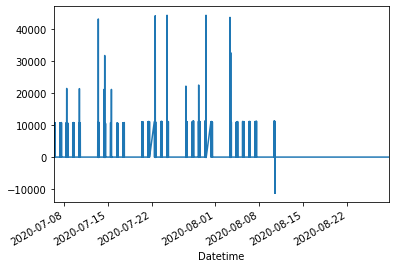

In [12]:
data['PnL'].plot()

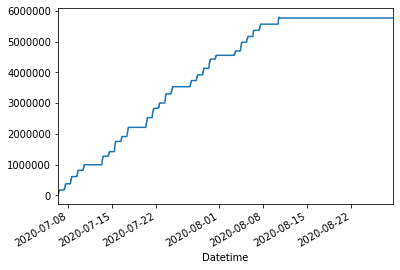

In [13]:
data['PnL'].cumsum().plot()